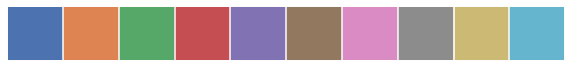

In [231]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)
import json
from pandas.io.json import json_normalize
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [226]:
results = {
    'b-resnet' : pd.read_json('../edge_test/nuc_2_jetson_b-resnet.json'),
    'b-densenet' : pd.read_json('../edge_test/nuc_2_jetson_b-densenet.json')
}

top-5 accuracy

In [227]:
top5  = { x : np.array(results[x].loc[(results[x]['index_top5'] != -1)].groupby('exit').count()['index_top5'].tolist()) / 5000 for x in results }
top5

{'b-resnet': array([0.738 , 0.8792, 0.9648, 0.9696]),
 'b-densenet': array([0.7862, 0.917 , 0.9452, 0.965 ])}

In [138]:
top1 = {x : np.array(results[x].loc[(results[x]['correct'] == True)].groupby('exit').count()['correct'].tolist()) / 5000 for x in results }
top1

{'b-resnet': array([0.4394, 0.6684, 0.8698, 0.8826]),
 'b-densenet': array([0.5114, 0.7452, 0.8292, 0.866 ])}

In [131]:
combined_top5 = {}
for net in results:
    all_wrong = 0
    for _, d in results[net].groupby('sample'):
        if all(i == -1 for i in d.index_top5.tolist()):
            all_wrong +=1 
    combined_top5[net] = (5000 - all_wrong) / 5000
combined_top5

{'b-resnet': 0.9824, 'b-densenet': 0.978}

In [133]:
combined_top1 = {}
for net in results:
    one_is_right = 0
    for _, d in results[net].groupby('sample'):
        if any(i==0 for i in d.index_top5.tolist()):
            one_is_right += 1
    combined_top1[net] = one_is_right / 5000
combined_top1

{'b-resnet': 0.9152, 'b-densenet': 0.9132}

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Exit-#')]

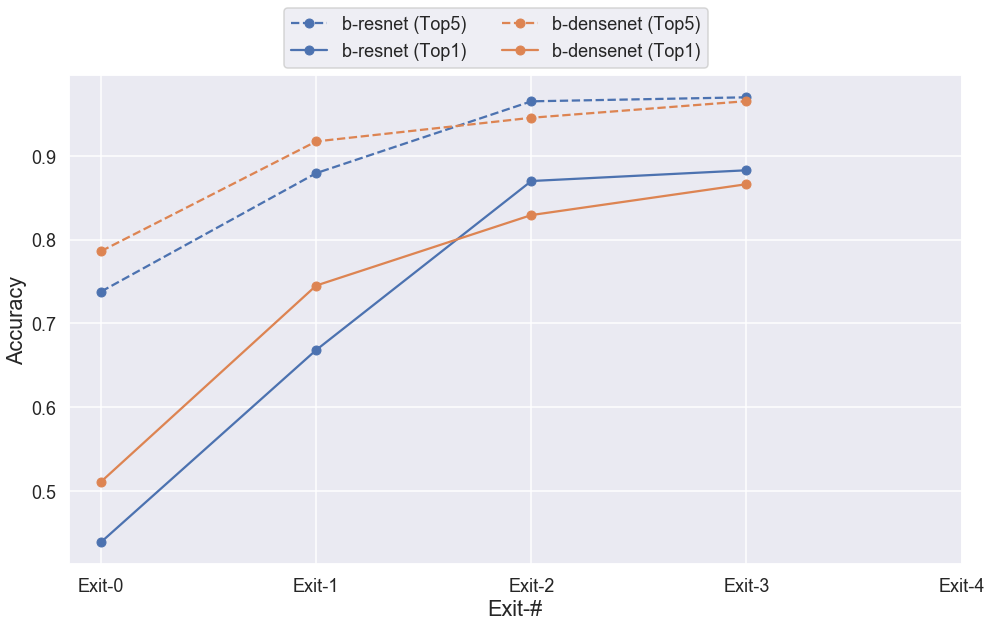

In [232]:
fig, ax = plt.subplots(1,1)
x = np.arange(5)
for i, net in enumerate(results):
    ax.plot(top5[net], '--o', color=current_palette[i])
    ax.plot(top1[net], '-o', color=current_palette[i])
    
    
ax.set_xticks(x)
ax.set_xticklabels(['Exit-{}'.format(x) for x in range(5)])
fig.legend([val for sublist in [['{} (Top5)'.format(x) ]+ ['{} (Top1)'.format(x)] for x in results] for val in sublist], 
           ncol=2, loc="upper center", fontsize='medium')

ax.set(xlabel='Exit-#', ylabel='Accuracy')

In [179]:
[['Top1-{}'.format(x)] + ['Top5-{}'.format(x) ]for x in results]


['Top1-b-resnet', 'Top5-b-resnet', 'Top1-b-densenet', 'Top5-b-densenet']

In [328]:
nets = { net : {} for net in results}
for net in results:
    best_exit = np.zeros(4)
    best_score = np.zeros((4,4))
    highscore_incorrect = np.zeros((4,4))
    highscore_correct = np.zeros((4,4))
    worst_mistaken = np.zeros(4)
    for i, d in results[net].groupby('sample'):
        #tmp = d[np.argmax(d.scores.tolist()[0]):1]
        correct = np.array(d.correct.tolist())
        scores = np.array(d.scores.tolist())
        
        
#for n, c in enumerate(correct):
        for n in range(len(correct),0,-1):
            #print(n)
            correct = correct[:n]
            scores = scores[:,:n]
            e_highscore = np.argmax(scores) // 4
            #print(scores)
            
            best_score[n-1][e_highscore] +=1
        
            if correct[e_highscore] == False:
                #print(e_highscore)
                highscore_incorrect[n-1][e_highscore] += 1
            else:
                #print(e_highscore)
                highscore_correct[n-1][e_highscore] += 1 
        #worst_mistaken[combined_incorrect] +=1

    nets[net]['best exit scoring'] = best_score
    nets[net]['best score exit incorrect'] = highscore_incorrect
    nets[net]['best score exit correct'] = highscore_correct
nets

{'b-resnet': {'best exit scoring': array([[5000.,    0.,    0.,    0.],
         [ 171., 4829.,    0.,    0.],
         [ 171., 1392., 3437.,    0.],
         [  29.,  142., 1392., 3437.]]),
  'best score exit incorrect': array([[2803.,    0.,    0.,    0.],
         [ 100., 1576.,    0.,    0.],
         [ 100.,  407.,  383.,    0.],
         [  18.,   66.,  182.,  337.]]),
  'best score exit correct': array([[2197.,    0.,    0.,    0.],
         [  71., 3253.,    0.,    0.],
         [  71.,  985., 3054.,    0.],
         [  11.,   76., 1210., 3100.]])},
 'b-densenet': {'best exit scoring': array([[5000.,    0.,    0.,    0.],
         [ 424., 4576.,    0.,    0.],
         [ 424., 2103., 2473.,    0.],
         [  41.,  383., 2103., 2473.]]),
  'best score exit incorrect': array([[2443.,    0.,    0.,    0.],
         [ 211., 1122.,    0.,    0.],
         [ 211.,  400.,  430.,    0.],
         [  34.,  121.,  261.,  283.]]),
  'best score exit correct': array([[2557.,    0.,    0.

In [383]:
nets[net]['best score exit incorrect']

array([[2443.,    0.,    0.,    0.],
       [ 211., 1122.,    0.,    0.],
       [ 211.,  400.,  430.,    0.],
       [  34.,  121.,  261.,  283.]])

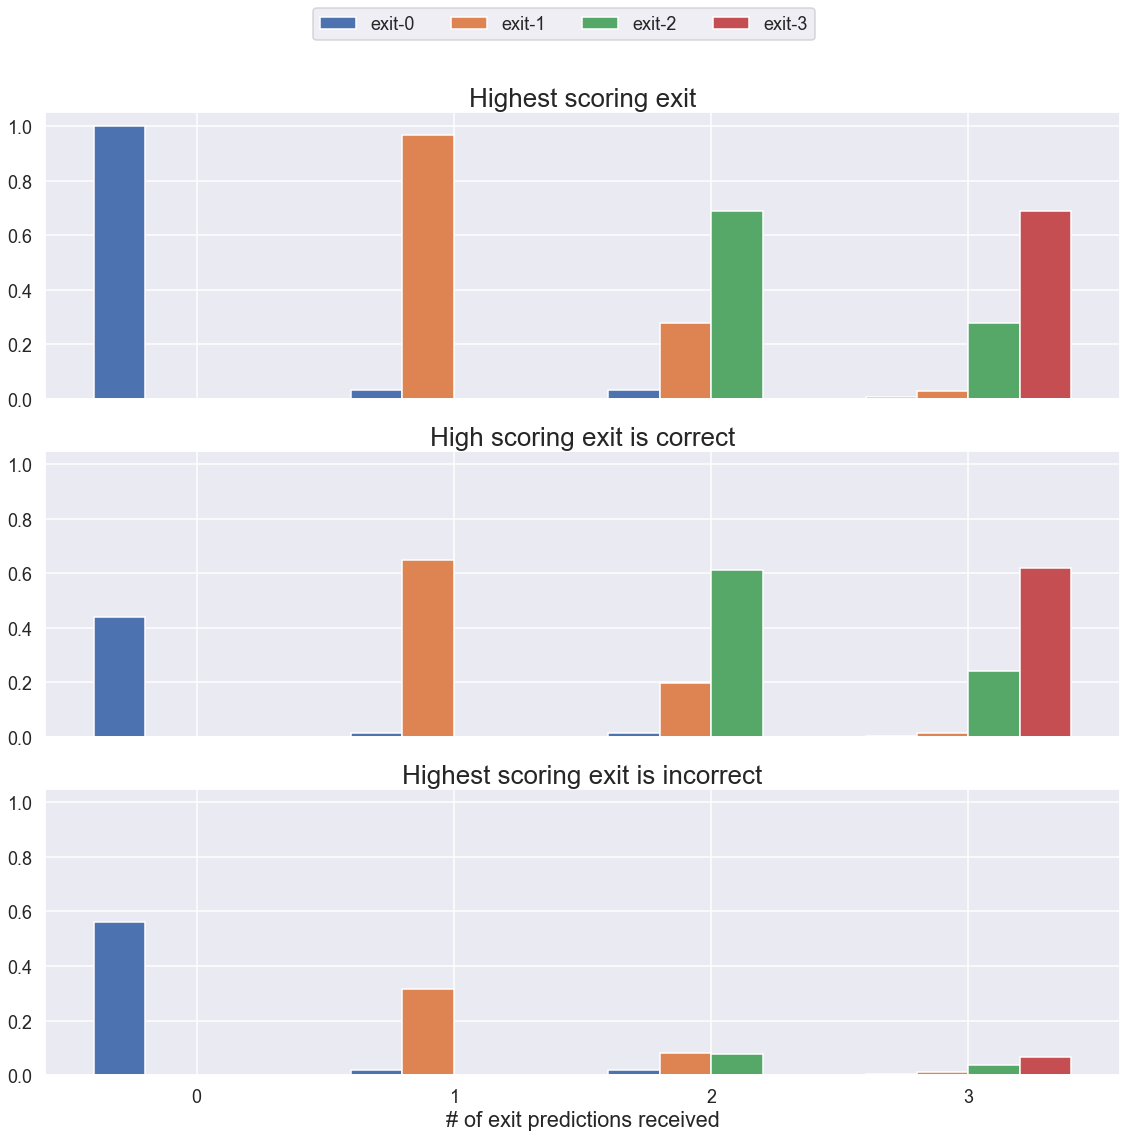

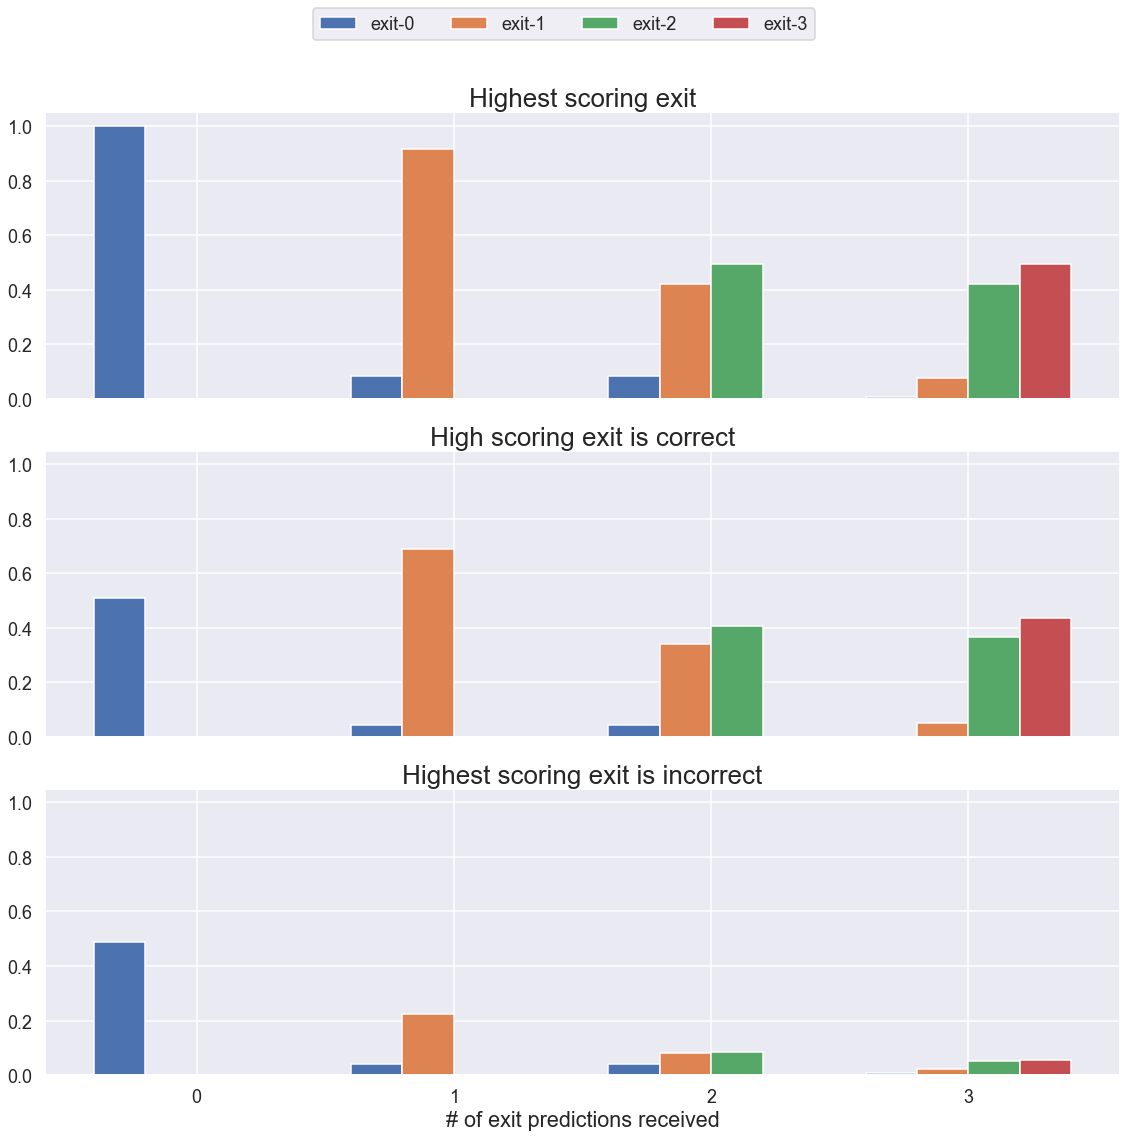

In [391]:
for net in nets:
    fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(16,16))
    x = np.arange(4)
    width = 0.2
    #ax.bar(x-width, best_exit, width=width)
    #ax.bar(x, best_score, width=width)
    #ax.bar(x+width, score_correct, width=width)
    for index_offset, exit_n in zip([-1.5,-.5,.5,1.5], range(4)):
        axes[0].bar(x+(width*index_offset), nets[net]['best exit scoring'].T[exit_n] /5000, width=width)
        axes[1].bar(x+(width*index_offset), nets[net]['best score exit correct'].T[exit_n] /5000, width=width)
        axes[2].bar(x+(width*index_offset), nets[net]['best score exit incorrect'].T[exit_n] /5000, width=width)

    for ax, title in zip(axes.flat, ['Highest scoring exit', 'High scoring exit is correct', 'Highest scoring exit is incorrect']):
        ax.set_xticks(x)
        ax.set_title(title)
        ax.set_xlabel('# of exit predictions received')
        ax.label_outer()
        #ax.set_xticklabels(label for label in nets[net])

    fig.legend(['exit-{}'.format(x) for x in range(4)], ncol=4, loc="upper center", fontsize='medium')
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.savefig(net + '_correctness.png')